## Assignment 1

Shahar Bardugo

Leah Wachtfogel

In [16]:
import numpy as np
from numpy import random
import math
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt

EPSILON = 1e-14

## 1. Forward Propagation Process

לשנות את כל הפרמטרים להיות כמו בעבודה. 
לבדוק איך אנשים הגדירו את דאבליו האם כמו מערך ? 
להוסיף הערות
לשים לב לאותיות קטנות וגדולות במילון
לא לשכוח את use_batchnorm


In [17]:
def	initialize_parameters(layer_dims):
  """Function to initialize W and b parameters of each layer.

    Parameters
    ----------
    layer_dims : list of int
        An array of the dimensions of each layer in the network (layer 0 is the
        size of the flattened input, layer L is the output softmax)

    Returns
    -------
    list of dict
        A list of dictionaries containing the initialized W and b parameters of
        each layer (W1…WL, b1…bL).

    """

  dict_list = []
  # Loop over each layer and initialize W and b
  for i in range(0, len(layer_dims) - 1):
      W = random.randn(layer_dims[i + 1], layer_dims[i]) 
      W = W * np.sqrt(1 / layer_dims[i])
      b = np.zeros((layer_dims[i + 1], 1))    
      dict_list.append({"W" : W , "b": b})
  return dict_list


def	linear_forward(A, W, b):
  """Computes the linear forward propagation of the neural network.

    Parameters
    ----------
    A : numpy.ndarray
        Input data of shape (size of previous layer, number of examples)
    W : numpy.ndarray
        Weight matrix of shape (size of current layer, size of previous layer)
    b : numpy.ndarray
        Bias vector of shape (size of current layer, 1)

    Returns
    -------
    numpy.ndarray
        Z - the input of the activation function
    dict
        linear_cashe - A dictionary containing "A", "W", and "b" for use in backpropagation.

    """
  Z = np.dot(W, A)+ b
   
  return Z, {"A":A, "W": W, "b": b} # linear cache


def	softmax(Z):
  """Computes the softmax activation function.

    Parameters
    ----------
    Z : numpy.ndarray
        the linear component of the activation function

    Returns
    -------
    numpy.ndarray
        A - the softmax activations of the layer
    dict
        activation_cache - A dictionary containing "Z" for use in backpropagation.

    """
  exp_max = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = exp_max / np.sum(exp_max, axis=0, keepdims=True)

  return A, {"Z": Z} # activation cache  


def relu(Z):
  """Computes the ReLU activation function.

    Parameters
    ----------
    Z : numpy.ndarray
        the linear component of the activation function

    Returns
    -------
    numpy.ndarray
        A - the ReLU activations of the layer
    dict
        activation_cache - A dictionary containing "Z" for use in backpropagation.

    """

  A = np.maximum(0, Z)
  return A, {"Z": Z} # activation cache


def linear_activation_forward(A_prev, W, B, activation):
  """Computes the forward propagation for a single layer with the given
    activation function.

    Parameters
    ----------
    A_prev : numpy.ndarray
        Input data
    W : numpy.ndarray
        Weight matrix
    b : numpy.ndarray
        Bias vector
    activation : str
        Activation function to be used in this layer, can be "softmax" or "relu"

    Returns
    -------
    numpy.ndarray
        A - output of the activation function
    dict
        caches - A dictionary containing the "linear_cache" and "activation_cache" for
        use in backpropagation.

    """

  Z, linear_cache = linear_forward(A_prev , W , B) 
  A, activation_cache = softmax(Z) if activation == "softmax" else \
                        relu(Z) if activation == "relu" else (None, None)
  return A, {"linear_cache" : linear_cache, "activation_cache" : activation_cache}   # linear + activation cache


def L_model_forward(X, parameters, use_batchnorm):
  """
    Forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation

    Inputs:
        X : np.ndarray 
          The input data 
        parameters : list[dict])
          List of parameters W and b of each layer.
        use_batchnorm : bool)
           A boolean indicating whether or not to apply batch 
           normalization after each activation.

    Outputs:
        AL : np.ndarray
           Probability vector of shape (output_size, number_of_examples).
        caches : list
           A list of caches for each layer. Each cache is a dictionary 
           containing "linear_cache" and "activation_cache" for that layer.
    """

  caches = [None] * len(parameters)
  A = X #np.array(X.copy())
  for i in range(0, len(parameters) - 1):
    A, cache = linear_activation_forward(A, parameters[i]["W"], parameters[i]["b"], "relu")
    caches[i] = cache
    if use_batchnorm:
      A = apply_batchnorm(A)
  AL, cache = linear_activation_forward(A, parameters[-1]["W"], parameters[-1]["b"], "softmax")
  caches[-1] = cache
  return AL, caches 


def compute_cost(AL, Y):

  m = AL.shape[1]
  cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL + EPSILON)))

  return cost # cross-entropy


def apply_batchnorm(A):

  mean_ = A.mean(axis = 0 )
  var_ = A.var(axis = 0)
  NA = (A - mean_) / np.sqrt(var_ + EPSILON ) 

  return NA #normalization activation


## 2. Backward Propagation Process

In [18]:
def	Linear_backward(dZ, cache):

  m = cache["A"].shape[1]
  dW = (1/m) * np.dot(dZ, cache["A"].T )
  db = (1/m) * np.sum(dZ , axis = 1)
  dA_prev = np.dot(cache["W"].T, dZ) 

  return dA_prev, dW, db


def	linear_activation_backward(dA, cache, activation):

  if activation == "relu":
    dZ = relu_backward(dA, cache["activation_cache"])
  elif activation == "softmax":
    dZ = softmax_backward(dA, cache["activation_cache"])  
  dA_prev, dW, db = Linear_backward(dZ, cache["linear_cache"])

  return dA_prev, dW, db


def	relu_backward(dA, activation_cache):

  Z = activation_cache["Z"]
  dZ = dA.copy()
  dZ[Z <= 0] = 0
  #dZ = activation_cache["Z"]
  #dZ[activation_cache["Z"] <= 0] = 0 
  #dZ[activation_cache["Z"] > 0] = 1
  #dZ = dZ * dA  

  return dZ


def	softmax_backward(dA, activation_cache):
  
  dZ = dA 

  return dZ


def	L_model_backward(AL, Y, caches):

  l = len(caches)

  dA = AL - Y
  dA_prev, dW, db = linear_activation_backward(dA, caches[-1], "softmax")
  Grads = {f"dA{l}" : dA , f"dW{l}" : dW , f"db{l}" : db}
  for i in range(l - 1 , 0, -1):    
     dA_prev, dW, db = linear_activation_backward(dA_prev, caches[i-1], "relu")
     Grads.update({f"dA{i}" : dA , f"dW{i}" : dW , f"db{i}" : db})

  return Grads 


def	Update_parameters(parameters, grads, learning_rate):

  l = len(parameters)
  for i in range(0, l):
    parameters[i]["W"] -= learning_rate * grads[f"dW{i+1}"]
    db = np.array([[x] for x in grads[f"db{i+1}"]])
    parameters[i]["b"] -= learning_rate * db
    
  return parameters


## Auxiliary functions‏

In [19]:
def split_data(X , Y, split_size): 

  num_samples = len(Y)
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  split_1 = indices[0 : int(num_samples*split_size)]
  split_2 = indices[int(num_samples*split_size) : num_samples]

  return X[split_1], X[split_2], Y[split_1], Y[split_2]

def to_categorial(Y):
  num_cat = len(np.unique(Y))
  categorial_matrix = np.zeros((len(Y), num_cat))
  for i in range(0, len(Y)):
    index = Y[i]
    categorial_matrix[i][index] = 1

  return categorial_matrix

## 3. Train Network and Produce Predictions

In [34]:
def	predict(X, Y, parameters):
  Y_pred, caches = L_model_forward(X.T, parameters, False)
  #print(Y_pred)
  list_results = np.where(Y == 1)[1] == np.argmax(Y_pred.T, axis = 1)
  #print(list_results)
  accuracy = (list_results.sum() / len(list_results)) * 100

  return accuracy

def	L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, batch_norm=False):

  perf = {"costs_val":[], "accuracy_val":[], "costs_train":[], "accuracy_train":[]}
  val_accuracy = []
  training_iteration = 0
  X_train , X_val , Y_train , Y_val  = split_data(X, Y, 0.8)
  parameters = initialize_parameters(layers_dims)
  for iter in range(0,num_iterations):
    i = 0
    while i < len(X_train) - 1:
      training_iteration += 1
      i_end = min(i+batch_size, len(X))
      X_batch = X_train[i : i_end]
      Y_batch = Y_train[i : i_end]       
      AL, caches = L_model_forward(X_batch.T, parameters, batch_norm)
      Y_train_p = AL.copy()
      Grads = L_model_backward(AL, Y_batch.T, caches)
      parameters = Update_parameters(parameters, Grads, learning_rate)
      if training_iteration % 100 == 0:

        Y_pred, caches = L_model_forward(X_val.T, parameters, batch_norm)
        cost = compute_cost(Y_pred, Y_val.T)
        accuracy = predict(X_val, Y_val, parameters)
        perf["costs_val"].append(cost)
        perf["accuracy_val"].append(accuracy)

        Y_pred, caches = L_model_forward(X_batch.T, parameters, batch_norm)
        cost_train = compute_cost(Y_pred, Y_batch.T)
        accuracy_train = predict(X_batch, Y_batch, parameters)
        perf["costs_train"].append(cost_train)
        perf["accuracy_train"].append(accuracy_train)
#        print(f"train cost: {cost_train}, train accuracy: {accuracy_train}, validation cost: {cost}, validation accuracy: {accuracy}")
        
        if len(perf["costs_val"]) > 1 and cost + EPSILON > perf["costs_val"][-2] and iter > 30: 
          print(" - - - - - - - - - - - - - - - - - -")
          print(f" - - - iterations = {iter} - - - ")
          return parameters, perf

      i += batch_size
  print(" - - - - - - - - - - - - - - - - - -")
  print(f" - - - iterations = {iter} - - - ")
  return parameters, perf




## 4. Classifying MNIST Dataset and Summary

In [32]:

def draw_performance(batch_size, batch_norm, performance, analysis):
  #training_iteration
  plt.figure(figsize=(5, 3))
  plt.plot(range(0, len(performance[f"{analysis}_val"]) * 100 , 100), performance[f"{analysis}_val"], label = "validation")
  plt.plot(range(0, len(performance[f"{analysis}_train"]) * 100 , 100), performance[f"{analysis}_train"], label = "train")
  plt.legend()
  plt.xlabel("#iterations")
  plt.ylabel(analysis)
  plt.title(f"Model Train and Validation {analysis}\nbatch size={batch_size}, batch norm={batch_norm}")
  plt.show()


def run_MNIST_NN(batch_norm, batch_size):
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  x_train = x_train/255
  x_test = x_test/255

  input_num = 28 * 28
  X_train = np.reshape(x_train, (len(x_train), input_num))
  X_test = np.reshape(x_test, (len(x_test), input_num))

  layers_dims = [784, 20, 7, 5, 10]
  learning_rate = 0.009
  num_iterations = 100000

  start = time.time()
  parameters , performance = L_layer_model(X_train, to_categorial(y_train), layers_dims, learning_rate, num_iterations, batch_size, batch_norm)
  end = time.time()
  print(f" - - - batch_size = {batch_size} - - - ")
  print(f" - - - batch_norm = {batch_norm} - - - ")
  print(f"time: {end - start} Sec")  
  acc = predict(X_test, to_categorial(y_test), parameters)
  acc_t = performance["accuracy_train"][-1]
  acc_v = performance["accuracy_val"][-1]
  print(f"Train Accuracy: {acc_t}")
  print(f"Validation Accuracy: {acc_v}")
  print(f"Test Accuracy: {acc}")
  num_iter = len(performance["costs_val"]*100)
  print(f"num of iterations: {num_iter}")
  print(f"time: {end - start} Sec")
  draw_performance(batch_size, batch_norm, performance, "costs")
  draw_performance(batch_size, batch_norm, performance, "accuracy")


 - - - - - - - - - - - - - - - - - -
 - - - iterations = 607 - - - 
 - - - batch_size = 512 - - - 
 - - - batch_norm = True - - - 
time: 434.9846351146698 Sec
Train Accuracy: 77.9296875
Validation Accuracy: 79.25
Test Accuracy: 78.91
num of iterations: 57100
time: 434.9846351146698 Sec


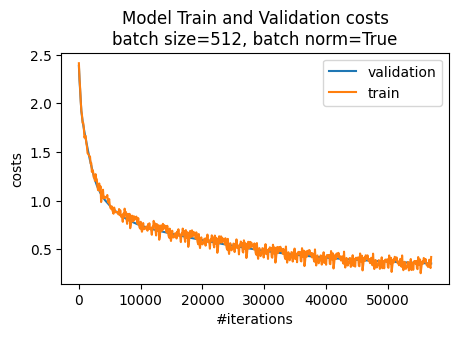

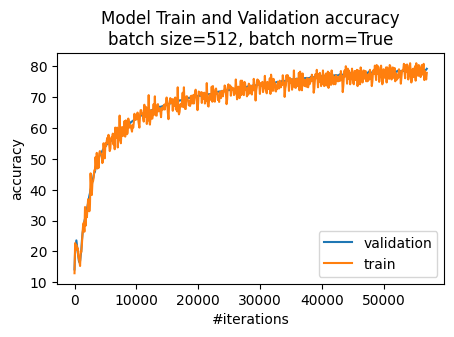

In [35]:
#run_MNIST_NN(False, 512)
#run_MNIST_NN(False, 128)
#run_MNIST_NN(False, 32)

run_MNIST_NN(True, 512)
#run_MNIST_NN(True, 128)
#run_MNIST_NN(True, 32)